In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import itertools

import astropy
from astropy.table import Table

import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined
from astroML.classification import GMMBayes

import warnings
warnings.filterwarnings("ignore")

In [2]:
#per leggere i dati = uso indirizzo già scritto in path+il nome del file
path='./galaxyquasar.csv'
data=Table.read(path)
print(data[:5])

   u        g        r        i        z     class      z1        zerr    
-------- -------- -------- -------- -------- ------ --------- ------------
18.97213 18.53676  18.5828 18.34936 18.29215    QSO 0.5228189 0.0001547483
19.24592 17.47646 16.47817 16.04472 15.68851 GALAXY 0.1228459 2.816076e-05
19.43536 17.70268 16.91565 16.58327 16.39128 GALAXY       0.0          0.0
19.31626 18.18312 17.39591 16.94549 16.65395 GALAXY 0.1474355 9.310701e-06
19.28828 19.11188 18.88937 18.80013 18.49183    QSO  2.011455 0.0006307968


In [3]:
#saving data (none of them has nan)
u=np.array(data['u'])
g=np.array(data['g'])
r=np.array(data['r'])
i=np.array(data['i'])
z=np.array(data['z'])

ug=u-g
gr=g-r
ri=r-i
iz=i-z
color=np.array([ug,gr,ri,iz])

#saving the classes => galaxy = 0, quasar = 1
label_class=np.array([data['class']=='QSO']).astype(int)

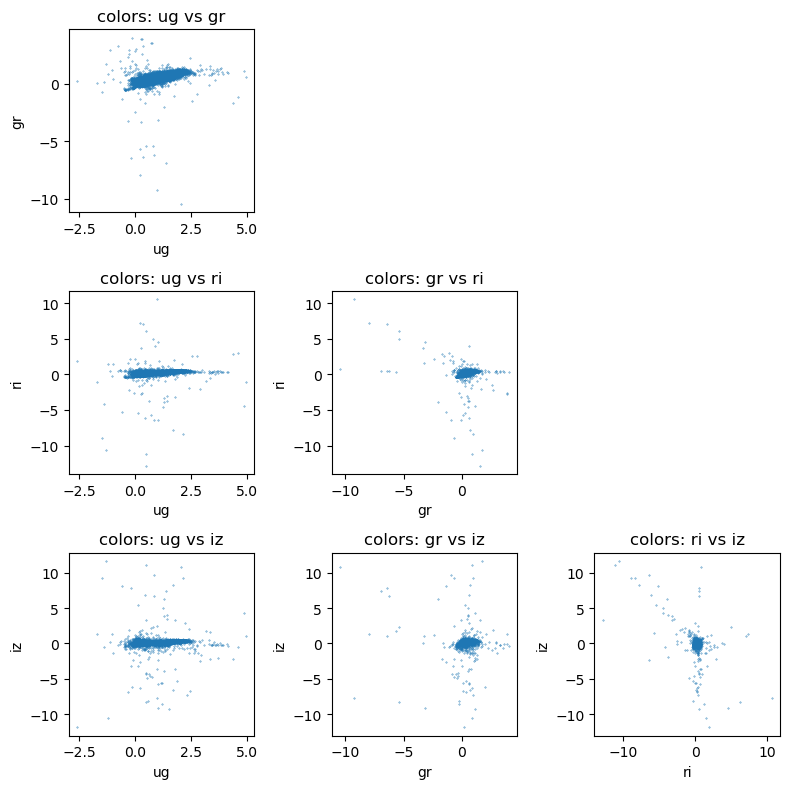

In [4]:
# Create subplots
labels=['ug','gr','ri','iz']
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Plot histograms and scatter plot
axes[0][0].scatter(color[0],color[1], s=0.1)
axes[0][0].title.set_text('colors: '+str(labels[0])+' vs '+str(labels[1]))
axes[0][0].set_xlabel(str(labels[0]))
axes[0][0].set_ylabel(str(labels[1]))
axes[0][1].axis("off")
axes[0][2].axis("off")
axes[1][0].scatter(color[0],color[2], s=0.1)
axes[1][0].title.set_text('colors: '+str(labels[0])+' vs '+str(labels[2]))
axes[1][0].set_xlabel(str(labels[0]))
axes[1][0].set_ylabel(str(labels[2]))
axes[1][1].scatter(color[1],color[2], s=0.1)
axes[1][1].title.set_text('colors: '+str(labels[1])+' vs '+str(labels[2]))
axes[1][1].set_xlabel(str(labels[1]))
axes[1][1].set_ylabel(str(labels[2]))
axes[1][2].axis("off")
axes[2][0].scatter(color[0],color[3], s=0.1)
axes[2][0].title.set_text('colors: '+str(labels[0])+' vs '+str(labels[3]))
axes[2][0].set_xlabel(str(labels[0]))
axes[2][0].set_ylabel(str(labels[3]))
axes[2][1].scatter(color[1],color[3], s=0.1)
axes[2][1].title.set_text('colors: '+str(labels[1])+' vs '+str(labels[3]))
axes[2][1].set_xlabel(str(labels[1]))
axes[2][1].set_ylabel(str(labels[3]))
axes[2][2].scatter(color[2],color[3], s=0.1)
axes[2][2].title.set_text('colors: '+str(labels[2])+' vs '+str(labels[3]))
axes[2][2].set_xlabel(str(labels[2]))
axes[2][2].set_ylabel(str(labels[3]))

plt.tight_layout()
plt.show()

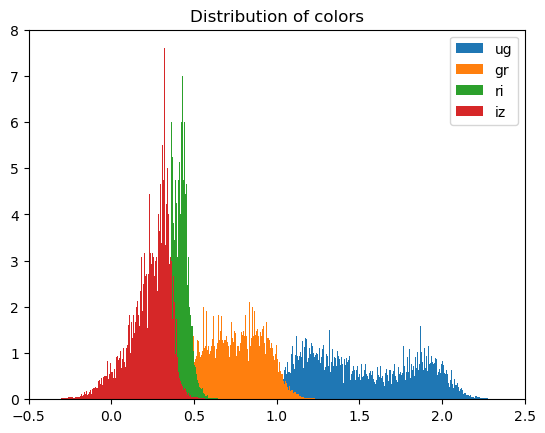

In [5]:
#histogram of the distribution of colors
N_bins=20
bins_set_ug=np.append(np.sort(ug)[::N_bins], np.max(ug))
bins_set_gr=np.append(np.sort(gr)[::N_bins], np.max(gr))
bins_set_ri=np.append(np.sort(ri)[::N_bins], np.max(ri))
bins_set_iz=np.append(np.sort(iz)[::N_bins], np.max(iz))

plt.hist(ug, bins=bins_set_ug, density=True, label='ug')
plt.hist(gr, bins=bins_set_gr, density=True, label='gr')
plt.hist(ri, bins=bins_set_ri, density=True, label='ri')
plt.hist(iz, bins=bins_set_iz, density=True, label='iz')
plt.title('Distribution of colors')
plt.legend()
plt.xlim(-0.5,2.5)
plt.ylim(0,8)
plt.show()

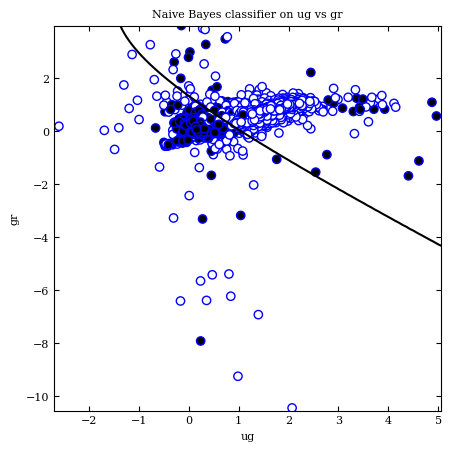

In [6]:
#Naive Bayes classifier (for 2 colors)

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#reshape of the data
X = np.hstack([color[0].reshape(-1,1),color[1].reshape(-1,1)])
y = (label_class.reshape(-1,1)).ravel() #reshape to have (nsample, 1) and then ravel for (nsample,)
clf = GaussianNB()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (color[0].min()-0.1, color[0].max()+0.1)
ylim = (color[1].min()-0.1, color[1].max()+0.)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()]) #gives probability for both class 1 and class 2 for each grid point
Z = Z[:, 1].reshape(xx.shape) #if degenerate=take just one and re-shape to grid pattern (for contour plotting)

#plot results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)

#add the decision boundary = contour where probability exceeds threshold (here=0.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Naive Bayes classifier on '+str(labels[0])+' vs '+ str(labels[1]))
ax.set_xlabel(str(labels[0]))
ax.set_ylabel(str(labels[1]))

plt.show()

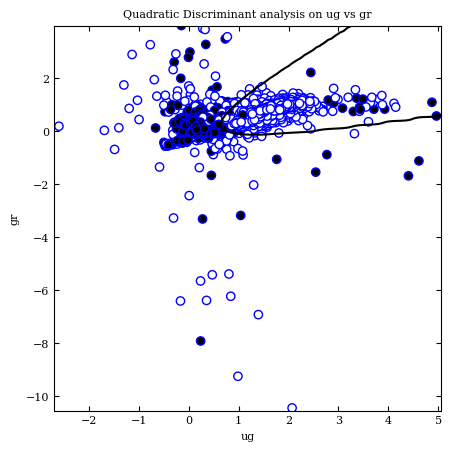

In [7]:
#Quadratic Discriminant analysis (for 2 colors)

#reshape of the data
X = np.hstack([color[0].reshape(-1,1),color[1].reshape(-1,1)])
y = (label_class.reshape(-1,1)).ravel() #reshape to have (nsample, 1) and then ravel for (nsample,)
clf = QuadraticDiscriminantAnalysis()
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (color[0].min()-0.1, color[0].max()+0.1)
ylim = (color[1].min()-0.1, color[1].max()+0.)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()]) #gives probability for both class 1 and class 2 for each grid point
Z = Z[:, 1].reshape(xx.shape) #if degenerate=take just one and re-shape to grid pattern (for contour plotting)

#plot results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)

#add the decision boundary = contour where probability exceeds threshold (here=0.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Quadratic Discriminant analysis on '+str(labels[0])+' vs '+ str(labels[1]))
ax.set_xlabel(str(labels[0]))
ax.set_ylabel(str(labels[1]))

plt.show()

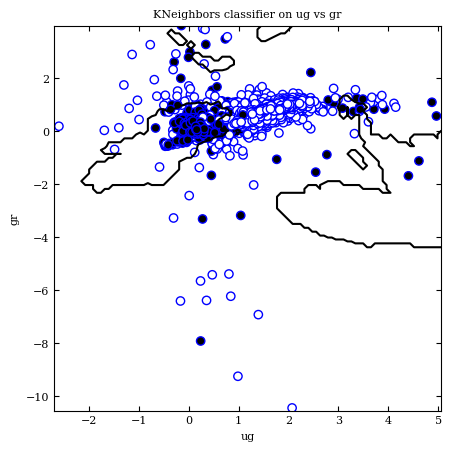

In [8]:
#KNeighbors Classifier (for 2 colors)

#reshape of the data
X = np.hstack([color[0].reshape(-1,1),color[1].reshape(-1,1)])
y = (label_class.reshape(-1,1)).ravel() #reshape to have (nsample, 1) and then ravel for (nsample,)
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (color[0].min()-0.1, color[0].max()+0.1)
ylim = (color[1].min()-0.1, color[1].max()+0.)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()]) #gives probability for both class 1 and class 2 for each grid point
Z = Z[:, 1].reshape(xx.shape) #if degenerate=take just one and re-shape to grid pattern (for contour plotting)

#plot results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)

#add the decision boundary = contour where probability exceeds threshold (here=0.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('KNeighbors classifier on '+str(labels[0])+' vs '+ str(labels[1]))
ax.set_xlabel(str(labels[0]))
ax.set_ylabel(str(labels[1]))

plt.show()

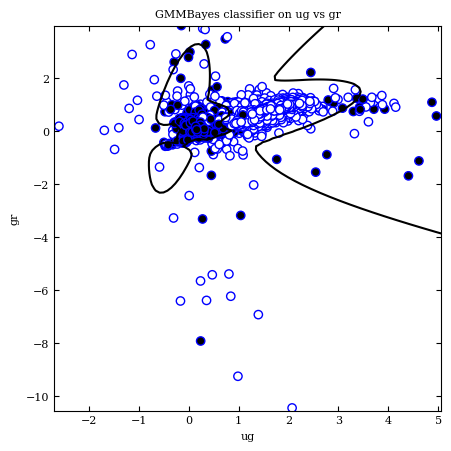

In [9]:
#GMMBayes Classifier (for 2 colors)

#reshape of the data
X = np.hstack([color[0].reshape(-1,1),color[1].reshape(-1,1)])
y = (label_class.reshape(-1,1)).ravel() #reshape to have (nsample, 1) and then ravel for (nsample,)
clf = GMMBayes(n_components=10)
clf.fit(X, y)

# predict the classification probabilities on a grid
xlim = (color[0].min()-0.1, color[0].max()+0.1)
ylim = (color[1].min()-0.1, color[1].max()+0.)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()]) #gives probability for both class 1 and class 2 for each grid point
Z = Z[:, 1].reshape(xx.shape) #if degenerate=take just one and re-shape to grid pattern (for contour plotting)

#plot results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary, zorder=2)

#add the decision boundary = contour where probability exceeds threshold (here=0.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('GMMBayes classifier on '+str(labels[0])+' vs '+ str(labels[1]))
ax.set_xlabel(str(labels[0]))
ax.set_ylabel(str(labels[1]))

plt.show()

In [10]:
#dividng in train and test for CV on numbers of neighbors and number GMM components
x_train_CV, x_test_CV, y_train_CV, y_test_CV = train_test_split(color[0:1].T, label_class.ravel(), test_size=0.3, random_state=42)

Number of neighbors= 2 0.12270755012281379 0.16832508230603463
Number of neighbors= 4 0.1296148139681572 0.1453730832490435
Number of neighbors= 6 0.13255726525328052 0.14212670403551894
Number of neighbors= 8 0.1337374827253537 0.13999999999999999
Number of neighbors= 10 0.13533028380331474 0.13784048752090222
Number of neighbors= 12 0.13564659966250536 0.14047538337136983
Number of neighbors= 14 0.13533028380331474 0.13999999999999999
Number of neighbors= 16 0.13585706774821418 0.1390443574307614
Number of neighbors= 18 0.13575187449376686 0.1390443574307614
Number of neighbors= 20 0.13617215994048543 0.13999999999999999
Number of neighbors= 22 0.13669569958749356 0.14023789311975085
Number of neighbors= 24 0.13763305250868027 0.1407124727947029
Number of neighbors= 26 0.1377368090650737 0.13976170195491086
Number of neighbors= 28 0.13835771443203715 0.13999999999999999
Best 10 0.13784048752090222


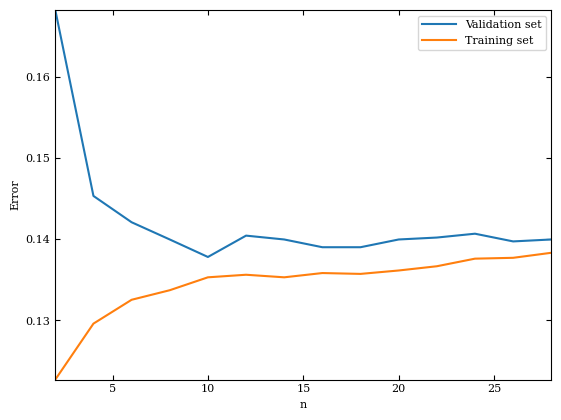

In [11]:
#range for which I test number of neighbors 
n_neighbors = np.arange(2,30,2)

err_train, err_test= [], []
for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_train_CV, y_train_CV)
    error_train = np.sqrt( np.sum((y_train_CV-clf.predict(x_train_CV) )**2) / len(x_train_CV) )
    error_validation = np.sqrt( np.sum((y_test_CV-clf.predict(x_test_CV) )**2) / len(x_test_CV) )

    #value of error in train and test
    print("Number of neighbors=",n, error_train, error_validation)
    err_train.append(error_train)
    err_test.append(error_validation)

plt.plot(n_neighbors,err_test, label='Validation set')
plt.plot(n_neighbors,err_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

#find the best number of neighbors from minimum of test
best_n_neighbors=n_neighbors[np.argmin(err_test)]
print("Best", best_n_neighbors, min(err_test))

plt.show()

Number of components= 2 0.14242792663559448 0.1432945684013645
Number of components= 4 0.14050927778213487 0.13880441875771343
Number of components= 6 0.13907860059281998 0.1361371857110809
Number of components= 8 0.13784048752090222 0.13490737563232041
Number of components= 10 0.13835771443203715 0.13564659966250536
Number of components= 12 0.13721724173212135 0.1361371857110809
Number of components= 14 0.1374253043864713 0.13490737563232041
Number of components= 16 0.13711309200802088 0.13515423288475528
Number of components= 18 0.1374253043864713 0.13589211407093005
Number of components= 20 0.1365911521920174 0.13441230102437302
Number of components= 22 0.1369045548652679 0.13515423288475528
Number of components= 24 0.1368001670842756 0.1361371857110809
Number of components= 26 0.13648652471424214 0.13662601021279466
Number of components= 28 0.13752921767495704 0.13564659966250536
Best 20 0.13441230102437302


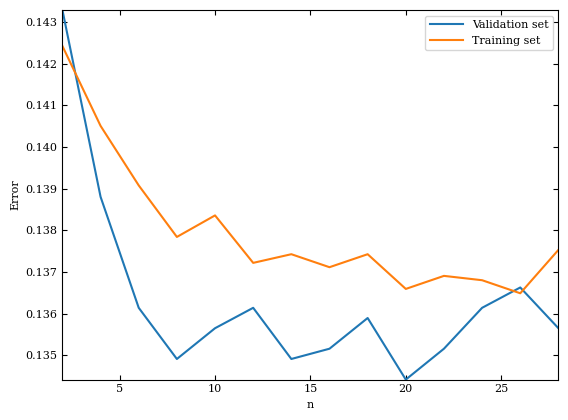

In [12]:
#range for which I test number of components of GMM
n_components = np.arange(2,30,2)

err_train, err_test= [], []
for n in n_components:
    clf = GMMBayes(n_components=n)
    clf.fit(x_train_CV, y_train_CV)
    error_train = np.sqrt( np.sum((y_train_CV-clf.predict(x_train_CV) )**2) / len(x_train_CV) )
    error_validation = np.sqrt( np.sum((y_test_CV-clf.predict(x_test_CV) )**2) / len(x_test_CV) )

    #value of error in train and test
    print("Number of components=",n, error_train, error_validation)
    err_train.append(error_train)
    err_test.append(error_validation)

plt.plot(n_components,err_test, label='Validation set')
plt.plot(n_components,err_train, label='Training set')

plt.xlabel('n')
plt.ylabel('Error')
plt.legend()

#find the best number of components from minimum of test
best_n_components=n_components[np.argmin(err_test)]
print("Best", best_n_components, min(err_test))

plt.show()

In [13]:
#dividng in train and test
x_train, x_test, y_train, y_test = train_test_split(color.T, label_class.ravel(), test_size=0.3, random_state=42)

In [14]:
names_models=((GaussianNB, {}), (QuadraticDiscriminantAnalysis, {}), (KNeighborsClassifier, dict(n_neighbors=best_n_neighbors)), (GMMBayes, dict(n_components=best_n_components)))
score_tot=np.zeros((4,4))
def compute_models(*args):
    probs_tot=[]
    for i in range(len(color)):
        probs = []
        j=0
        for classifier, kwargs in args:
            clf = classifier(**kwargs)
            clf.fit(x_train[:, 0:i+1], y_train)
            
            score_tot[i][j]=clf.score(x_test[:, 0:i+1], y_test)
            y_probs = clf.predict_proba(x_test[:, 0:i+1])[:,1]

            probs.append(y_probs)
            j=j+1
        probs_tot.append(probs)

    return probs_tot

In [15]:
all_probs = compute_models((GaussianNB, {}), (QuadraticDiscriminantAnalysis, {}), (KNeighborsClassifier, dict(n_neighbors=best_n_neighbors)), (GMMBayes, dict(n_components=best_n_components)))

fpr_tot, tpr_tot, thresh_tot=[], [], []

for i in range(len(color)):
    fpr_app, tpr_app, thresh_app= [], [], []
    for j in range(len(names_models)):
        fpr, tpr, thresh = roc_curve(y_test, all_probs[i][j])
        fpr_app.append(fpr)
        tpr_app.append(tpr)
        thresh_app.append(thresh)
    fpr_tot.append(fpr_app)
    tpr_tot.append(tpr_app)
    thresh_tot.append(thresh_app)

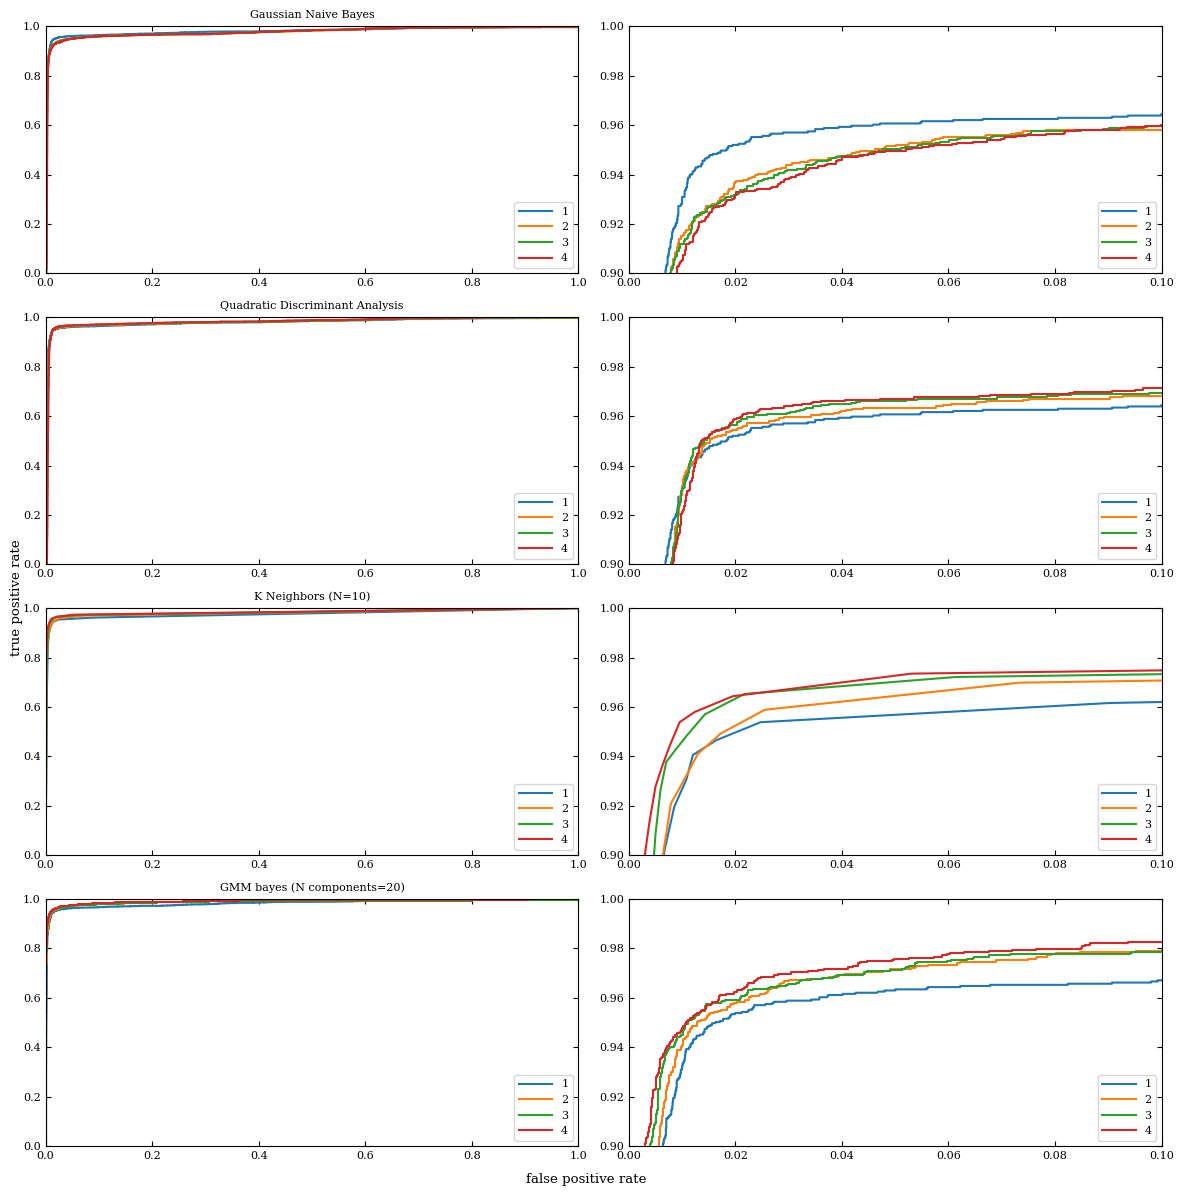

In [16]:
names=['Gaussian Naive Bayes', 'Quadratic Discriminant Analysis', 'K Neighbors (N='+str(best_n_neighbors)+')', 'GMM bayes (N components='+str(best_n_components)+')']
fig, axes = plt.subplots(len(names_models), 2, figsize=(12, 12))
for j in range(len(names_models)):
    for i in range(len(color)):
        axes[j][0].plot(fpr_tot[i][j], tpr_tot[i][j], label=str(i+1))
    axes[j][0].legend(loc='lower right')
    axes[j][0].title.set_text(str(names[j]))
    for i in range(len(color)):
        axes[j][1].plot(fpr_tot[i][j], tpr_tot[i][j], label=str(i+1))
        axes[j][1].legend(loc='lower right')
    axes[j][1].set_xlim(0,0.1)
    axes[j][1].set_ylim(0.9,1)
fig.supxlabel('false positive rate')
fig.supylabel('true positive rate')
plt.tight_layout()
plt.show()

In [17]:
#.score = mean accuracy = correct predictions of the model
print('Mean scores for the classifiers:')
print(names[0], ': \t\t ', score_tot[0])
print('\t\t\t\t   Maximum score: ', round(score_tot[0].max(),3), ' with ', score_tot[0].argmax()+1, 'features')
print(names[1], ':', score_tot[1])
print('\t\t\t\t   Maximum score: ', round(score_tot[1].max(),3), ' with ', score_tot[1].argmax()+1, 'features')
print(names[2], ': \t\t ', score_tot[2])
print('\t\t\t\t   Maximum score: ', round(score_tot[2].max(),3), ' with ', score_tot[2].argmax()+1, 'features')
print(names[3], ':\t ', score_tot[3])
print('\t\t\t\t   Maximum score: ', round(score_tot[3].max(),3), ' with ', score_tot[3].argmax()+1, 'features')

Mean scores for the classifiers:
Gaussian Naive Bayes : 		  [0.9814 0.9814 0.981  0.982 ]
				   Maximum score:  0.982  with  4 features
Quadratic Discriminant Analysis : [0.9754     0.98166667 0.98173333 0.98313333]
				   Maximum score:  0.983  with  4 features
K Neighbors (N=10) : 		  [0.9764     0.9808     0.98493333 0.9844    ]
				   Maximum score:  0.985  with  3 features
GMM bayes (N components=20) :	  [0.97513333 0.97986667 0.98533333 0.98473333]
				   Maximum score:  0.985  with  3 features
